In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import torch.nn.functional as F
# from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import vector
from tqdm.notebook import tqdm
import yaml

## Loading yaml params

In [2]:
yaml_name='Aug13_on.yaml'

In [3]:
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")

yaml_file_path= os.path.join(base_path, "fnn_FeatureRegression", 'yamls', yaml_name)
with open(yaml_file_path, 'r') as yaml_file:
    loaded_data = yaml.load(yaml_file, Loader=yaml.SafeLoader)

# Extract the general configurations
data_name = loaded_data['data_name']
batch_size = loaded_data['batch_size']
early_stop_patience = loaded_data['early_stop_patience']
learning_rate = loaded_data['learning_rate']
Local_model=loaded_data['Local_model']
model_save_prefix=loaded_data['model_save_prefix']

# Extracting model configurations
models = loaded_data['models']
hidden_layers_list_loaded = [model['hidden_layers'] for model in models]
activation_fn_names_loaded = [model['activation_fn'] for model in models]

# Map function names back to their actual functions
activation_fn_mapping = {
    'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh
}

# Convert function names to actual functions
activation_fn_list_loaded = [activation_fn_mapping[name] for name in activation_fn_names_loaded]


In [4]:
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
# with open(os.path.join(full_folder_path,"Aug10_5mil.pkl"), 'rb') as f:
with open(os.path.join(full_folder_path,data_name), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
numevents=len(clean_data_dict['2_phi'])
print("number of events:",numevents)

data_dict=clean_data_dict
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])

yaml_file_path= os.path.join(base_path, "fnn_FeatureRegression", 'yamls', yaml_name)

dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [5]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'], 
    ['deltaphi_13', 'deltaeta_13', 'deltaR_13', 'mt_13', 'norm_mt_13'], 
    ['deltaphi_23', 'deltaeta_23', 'deltaR_23', 'mt_23', 'norm_mt_23']
]

lepton_input_ordered = input_data_names_ordered[1:]
lepton_output_ordered = used_labels2[3:]

l_input_shape=(numevents,len(lepton_input_ordered), len(lepton_input_ordered[0]))
print("events, particles, input features: ",l_input_shape)
l_input= np.empty(l_input_shape)

for i in range(len(lepton_input_ordered)):
    for j, feature in enumerate(lepton_input_ordered[i]):
        l_input[:,i,j] = data_dict_np[feature]

l_output_shape=(numevents, len(lepton_output_ordered), len(lepton_output_ordered[0]))
print("events, particle pairs, output kin. features: ",l_output_shape)
l_output= np.empty(l_output_shape)

for i in range(len(lepton_output_ordered)):
    for j, feature in enumerate(lepton_output_ordered[i]):
        l_output[:,i,j] = data_dict_np[feature]

lepton_pair_order = pair_order[3:]
lepton_particle_order = input_data_particle_order[1:]
print("lepton pair order: ", lepton_pair_order)
print("lepton particle order: ", lepton_particle_order)

events, particles, input features:  (2844237, 3, 4)
events, particle pairs, output kin. features:  (2844237, 3, 5)
lepton pair order:  ['1_2', '1_3', '2_3']
lepton particle order:  ['1', '2', '3']


In [6]:
def add_extra_features(data):
    p1_pt=data['pt_1']
    p2_pt=data['pt_2']
    p3_pt=data['pt_3']

    p1_phi=data["1_phi"]
    p2_phi=data["2_phi"]
    p3_phi=data["3_phi"]

    p1_eta=data["eta_1"]
    p2_eta=data["eta_2"]
    p3_eta=data["eta_3"]

    p1_mass=data["mass_1"]
    p2_mass=data["mass_2"]
    p3_mass=data["mass_3"]

    particle1=vector.arr({"pt": p1_pt, "phi": p1_phi, "eta": p1_eta, "mass": p1_mass})
    particle2=vector.arr({"pt": p2_pt, "phi": p2_phi, "eta": p2_eta, "mass": p2_mass})
    particle3=vector.arr({"pt": p3_pt, "phi": p3_phi, "eta": p3_eta, "mass": p3_mass})

    p4_mother12=particle1+particle2
    p4_mother23=particle2+particle3
    p4_mother13=particle1+particle3

    pairs=['12','13','23']
    motherpairs=[p4_mother12, p4_mother13, p4_mother23]
    features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
    # features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz']

    add_feat_size=(len(data['pt_1']), len(pairs), len(features_toadd))
    add_feat_array= np.empty(add_feat_size)

    for feature in features_toadd:
        for i, pair in enumerate(pairs):
           add_feat_array[:, i, features_toadd.index(feature)] = getattr(motherpairs[i], feature)
    return add_feat_array

    
    # for i, pair in enumerate(pairs):
    #     features_toadd=[ 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
    #     for feature in features_toadd:
    #         data['mother_' + feature + '_' + pair] = motherpairs[i].feature
    # return data

data_conc=add_extra_features(data_dict_np)
print(data_conc.shape)
# print(data_new.columns)
l_output2= np.concatenate((l_output, data_conc), axis=2)
print("l_output new shape: ",l_output2.shape)

n_l_input = l_input
n_l_output = l_output2

(2844237, 3, 8)
l_output new shape:  (2844237, 3, 13)


## Normalizing

In [7]:
def normalize_l(data):
    means = data.mean(axis=(0))
    stds = data.std(axis=(0))

    data_normalized = (data - means) / (stds + 1e-10)
    return data_normalized, means, stds

# n_l_input, _, _ = normalize_l(l_input)
# print("normalized input shape:",n_l_input.shape)


n_l_output, l_output_means, l_output_stds = normalize_l(l_output2)
# print("normalized output shape:",n_l_output.shape)
n_l_input = l_input
# n_l_output = l_output2

def invert_normalize(data_normalized, means, stds):
    return (data_normalized * stds) + means



## Converting to tensor and adding pairs ##

In [8]:
linput_tensor = torch.tensor(n_l_input, dtype=torch.float32)
llabel_tensor = torch.tensor(n_l_output, dtype=torch.float32)

lpairs_data=[]
lpairs_labels=[]

# lepton_pair_order = ['1_2', '1_3', '2_3']
lepton_pair_mapping={(0,1): lepton_pair_order.index('1_2'), (0,2): lepton_pair_order.index('1_3'), (1,2): lepton_pair_order.index('2_3')}

for key, value in lepton_pair_mapping.items():
    concatonated_data=torch.cat((linput_tensor[:,key[0],:], linput_tensor[:,key[1],:]), dim=1)
    lpairs_data.append(concatonated_data)

    lpairs_labels.append(llabel_tensor[:,value,:])

print(len(lpairs_data), len(lpairs_labels))
print(lpairs_data[0].shape, lpairs_labels[0].shape)

3 3
torch.Size([2844237, 8]) torch.Size([2844237, 13])


## Making training data ##

In [9]:
train_data_list = []
val_data_list = []
test_data_list = []
train_labels_list = []
val_labels_list = []
test_labels_list = []

for pair_idx in range(len(lpairs_data)):
    pair_data = lpairs_data[pair_idx]
    pair_labels = lpairs_labels[pair_idx]

    train_val_data, test_data, train_val_labels, test_labels = train_test_split(pair_data, pair_labels, test_size=0.2, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=42)

    train_data_list.append(train_data)
    val_data_list.append(val_data)
    test_data_list.append(test_data)
    train_labels_list.append(train_labels)
    val_labels_list.append(val_labels)
    test_labels_list.append(test_labels)

class ParticleDataset(Dataset):
    def __init__(self, data_list, labels_list):
        self.data_list = data_list
        self.labels_list = labels_list
    
    def __len__(self):
        return len(self.data_list[0])
    
    def __getitem__(self, idx):
        return [data[idx] for data in self.data_list], [label[idx] for label in self.labels_list]


## Defining Model ##

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


class CustomKinematicNet(nn.Module):
    def __init__(self, input_size, hidden_layers, lenoutput, activation_fn=F.relu, dropout_prob=0.05):
        """
        Args:
        - input_size (int): Size of the input layer.
        - hidden_layers (list of int): Sizes of each hidden layer.
        - lenoutput (int): Size of the output layer.
        - activation_fn (callable): Activation function to use.
        """
        super(CustomKinematicNet, self).__init__()
        
        # Create the list of layers
        layers = [nn.Linear(input_size, hidden_layers[0])]
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        layers.append(nn.Linear(hidden_layers[-1], lenoutput))
        
        self.layers = nn.ModuleList(layers)
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_fn(layer(x))
            x = self.dropout(x)
        return self.layers[-1](x)

# hidden_layer_sizes = [128, 200, 300, 250, 128, 64]
lenoutput = l_output2.shape[2]
# model = CustomKinematicNet(input_size=10, hidden_layers=hidden_layer_sizes, lenoutput=lenoutput, activation_fn=F.relu)
# model.to(device)




cuda:0


## Training ##

In [11]:

def custom_loss(y_pred, y_true):

    # Compute MSE loss for each output individually
    mse_loss = F.mse_loss(y_pred, y_true, reduction='none')
    
    # # Compute RMSE for specific indices and replace in the MSE loss
    indices = [3, 6, 12]
    for idx in indices:
        RMSE = torch.abs(y_pred[:, idx]**2 - y_true[:, idx]**2) / torch.abs(y_true[:, idx])
        mask = y_true[:, idx] > 1
        mse_loss[mask, idx] = RMSE[mask]
    
    # Calculate average loss of each output
    avg_loss_per_output = mse_loss.mean(dim=0)  # Averaging over the batch dimension
    
    # Normalize the average loss by its maximum loss value
    # normalized_loss = avg_loss_per_output / avg_loss_per_output.max()
    normalized_loss=avg_loss_per_output
    # normalized_loss = avg_loss_per_output * output_loss_norm_tensor
    # print(avg_loss_per_output)
    # print(normalized_loss)
    # if normalized_loss.max()/ normalized_loss.min() > 100:
    #     print('Loss is not balanced: ', normalized_loss)
    total_loss = normalized_loss.mean()
    
    return total_loss

def train_one_epoch(model, data_loader, optimizer, device):
    model.train()
    total_train_loss = 0
    
    for data, labels in data_loader:
        data = [d.to(device) for d in data]
        labels = [l.to(device) for l in labels]
        
        optimizer.zero_grad()
        total_loss = 0
        for i in range(len(data)):
            y_pred = model(data[i])
            # loss = loss_fn(y_pred, labels[i])
            loss = custom_loss(y_pred, labels[i])
            total_loss += loss
        total_train_loss += total_loss.item()
        
        total_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(data_loader)
    return avg_train_loss


def validate_model(model, data_loader, device):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data = [d.to(device) for d in data]
            labels = [l.to(device) for l in labels]

            total_loss = 0
            for i in range(len(data)):
                y_pred = model(data[i])
                # loss = loss_fn(y_pred, labels[i])
                loss = custom_loss(y_pred, labels[i])                
                total_loss += loss
            total_val_loss += total_loss.item()

    avg_val_loss = total_val_loss / len(data_loader)
    return avg_val_loss


def test_model(model, data_loader, device):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data = [d.to(device) for d in data]
            labels = [l.to(device) for l in labels]

            total_loss = 0
            for i in range(len(data)):
                y_pred = model(data[i])
                # loss = loss_fn(y_pred, labels[i])
                loss = custom_loss(y_pred, labels[i])
                total_loss += loss
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(data_loader)
    return avg_test_loss

def main_training_loop(model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience, batch_size=320):
    epochs_no_improve = 0
    min_val_loss = np.Inf


    train_dataset = ParticleDataset(train_data_list, train_labels_list)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = ParticleDataset(val_data_list, val_labels_list)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = ParticleDataset(test_data_list, test_labels_list)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        # model, data_loader, optimizer, device
        # train_loss = train_one_epoch(model, train_data_list, train_labels_list, optimizer, loss_fn, device)
        val_loss = validate_model(model, val_loader, device)
        # val_loss = validate_model(model, val_loader, loss_fn, device)
        # val_loss = validate_model(model, val_data_list, val_labels_list, loss_fn, device)
        
        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
            saved_model = model.state_dict()
            # torch.save(model.state_dict(), 'fnn_FeatureRegression/fnn_try4.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_patience:
                print('Early stopping!')
                return saved_model
        if (epoch +1) % 5 == 0:
            # test_loss = test_model(model, test_data_list, test_labels_list, loss_fn, device)
            # test_loss = test_model(model, test_loader, loss_fn, device)
            test_loss = test_model(model, test_loader, device)
            print(f"Epoch [{epoch + 1}], "
            f"Train Loss: ({train_loss*1000:.4f}), "
                f"Val Loss: ({val_loss*1000:.4f}), "
                f"Test Loss: ({test_loss*1000:.4f})")
        
        else:
            print(f"Epoch [{epoch + 1}], "
                f"Train Loss: ({train_loss*1000:.4f}), "
                f"Val Loss: ({val_loss*1000:.4f})")

In [10]:
num_epochs = 100000
loss_fn = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

saved_models = []


hidden_layers_list = hidden_layers_list_loaded
activation_fn_list = activation_fn_list_loaded

pbar = tqdm(hidden_layers_list, total=len(hidden_layers_list))

for i, hidden_layers_curr in enumerate(pbar):
    pbar.set_description(f"model [{i+1}/{len(hidden_layers_list)}]")
    # print(f"[{i+1}/{len(hidden_layers_list)}] Hidden Layers: {hidden_layers_curr}")
    curr_model= CustomKinematicNet(input_size=8, hidden_layers=hidden_layers_curr, lenoutput=lenoutput, activation_fn=activation_fn_list[i])
    curr_model.to(device)
    l2_reg_strength = 1e-4
    optimizer = torch.optim.Adam(curr_model.parameters(), lr=learning_rate, weight_decay=l2_reg_strength)
    curr_saved_model = main_training_loop(curr_model, num_epochs, train_data_list, train_labels_list, val_data_list, val_labels_list, optimizer, loss_fn, device, early_stop_patience, batch_size=batch_size)
    saved_models.append(curr_saved_model)



# Format: (MSE, RMSE)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1], Train Loss: (2148.5842), Val Loss: (1598.0769)
Epoch [2], Train Loss: (1606.2885), Val Loss: (1354.7183)
Epoch [3], Train Loss: (1315.1019), Val Loss: (688.2009)
Epoch [4], Train Loss: (894.9498), Val Loss: (480.3225)
Epoch [5], Train Loss: (767.7471), Val Loss: (413.9481), Test Loss: (416.6388)
Epoch [6], Train Loss: (719.6794), Val Loss: (397.0252)
Epoch [7], Train Loss: (688.7769), Val Loss: (373.2841)
Epoch [8], Train Loss: (664.1339), Val Loss: (350.3518)
Epoch [9], Train Loss: (639.8394), Val Loss: (332.2053)
Epoch [10], Train Loss: (616.5040), Val Loss: (309.2187), Test Loss: (310.9227)
Epoch [11], Train Loss: (597.4954), Val Loss: (287.9385)
Epoch [12], Train Loss: (580.8728), Val Loss: (273.9667)
Epoch [13], Train Loss: (568.6658), Val Loss: (263.6596)
Epoch [14], Train Loss: (558.2444), Val Loss: (253.5172)
Epoch [15], Train Loss: (551.1906), Val Loss: (259.3571), Test Loss: (260.8075)
Epoch [16], Train Loss: (544.6094), Val Loss: (239.6278)
Epoch [17], Train Loss:

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

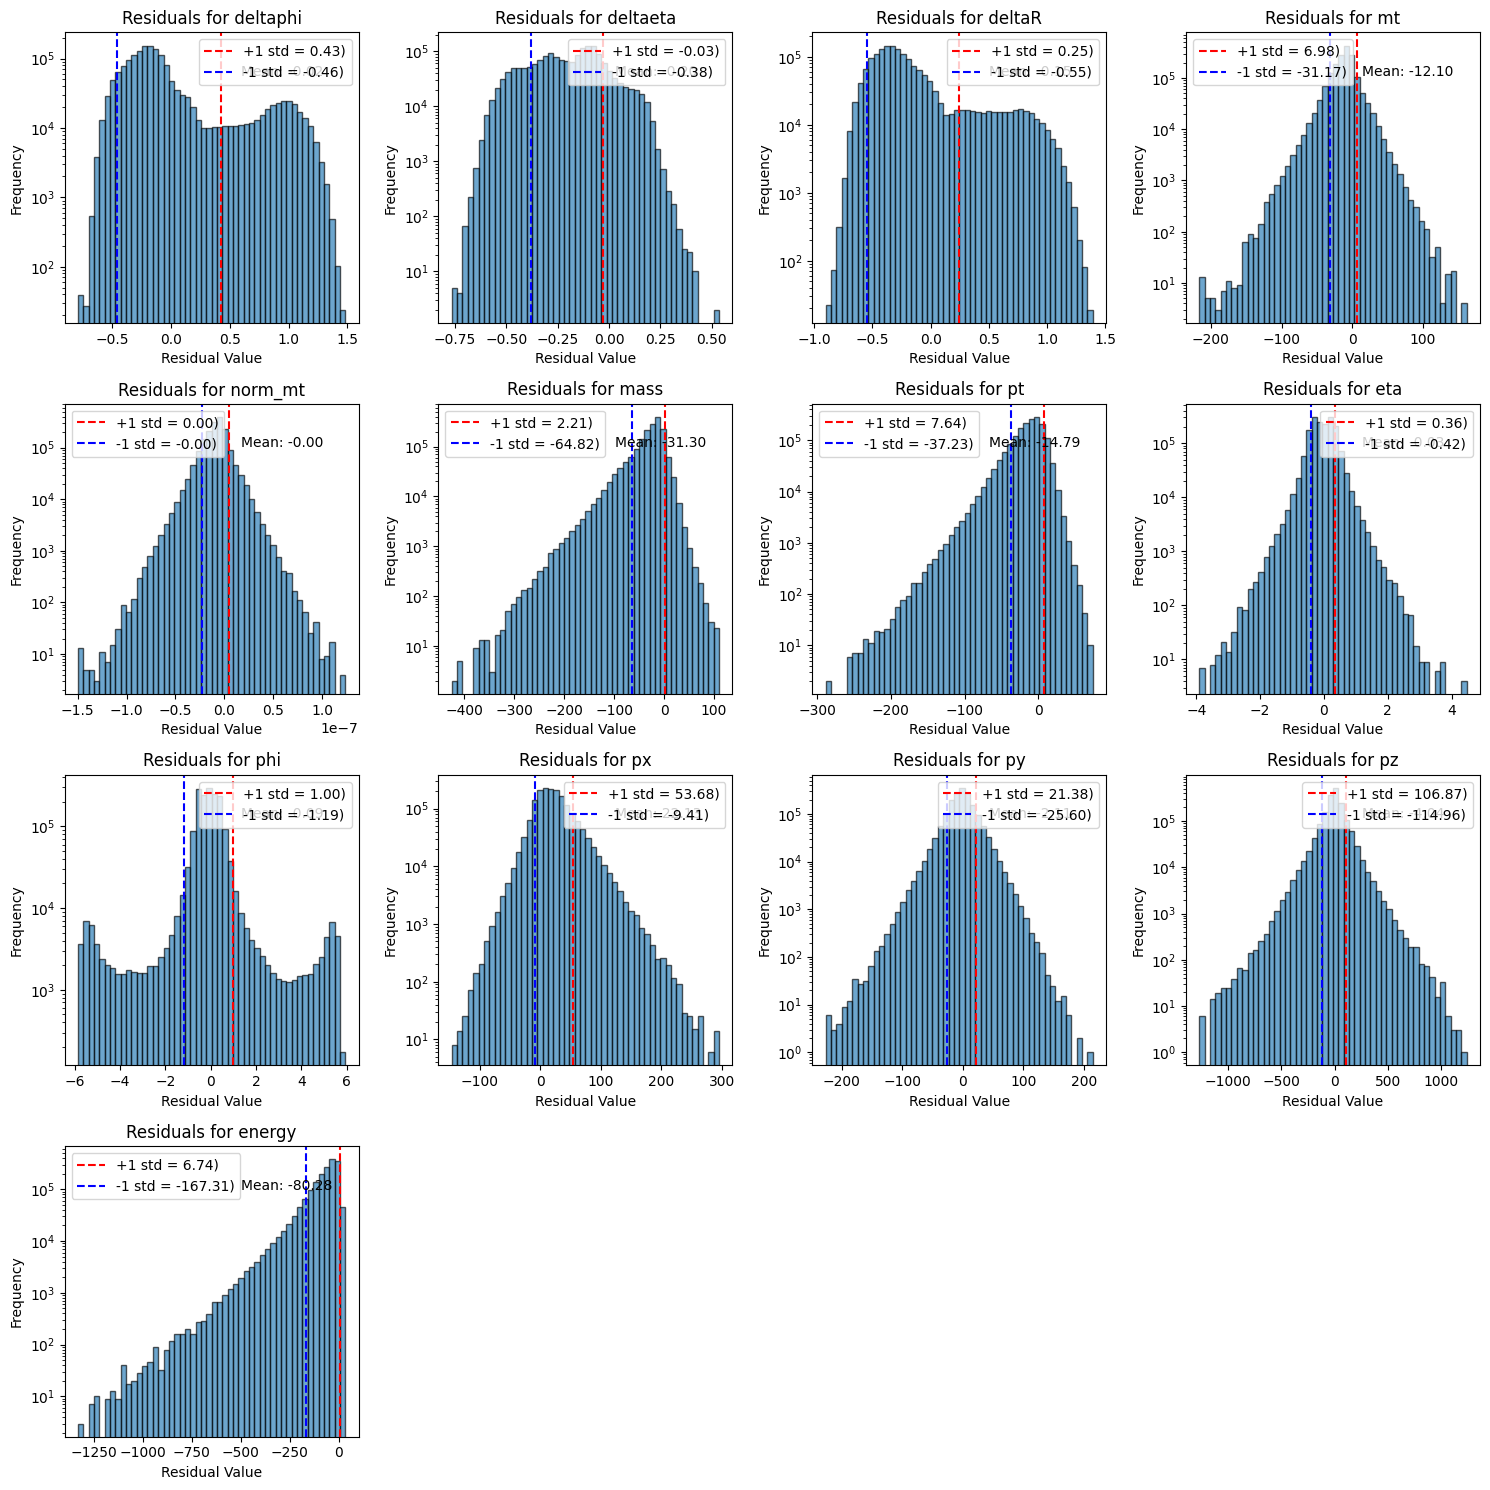

In [19]:
# saved_model = KinematicNet(lenoutput)

Local_model=False

if Local_model:
    model_loc=0
    plot_hidden_layer = hidden_layers_list[model_loc]
    print('plot_hidden_layer sizes', plot_hidden_layer)
    saved_model = CustomKinematicNet(input_size=8, hidden_layers=hidden_layers_list[model_loc], lenoutput=lenoutput, activation_fn=activation_fn_list[model_loc])
    saved_model.load_state_dict(saved_models[model_loc])
    saved_model.to(device)

else:
    model_loc=0
    # hidden_layers_list= [[32,32,32,32,32,32,32,32,32,32,32,32,32],
    #                  [32,32,32,32,32,32,32,32,32,32,32,32,32],
    #                  [32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32],
    #                  [32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32],
    #                  [32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32]]
    hidden_layers_list=hidden_layers_list_loaded
    activation_fn_list=[F.relu, F.sigmoid, F.relu, F.sigmoid, F.tanh]
    # saved_files/saved_models/FNN_FeatureRegression/fnn_try_aug11_1.pt
    # saved_files/saved_models/FNN_FeatureRegression/fnn_try_aug11_1.pt
    loaded_base= 'saved_files/saved_models/FNN_FeatureRegression/fnn_on_aug15__'

    model_name= loaded_base + str(model_loc+1) + '.pt'
    mdoel_full_name = os.path.join(base_path, model_name)

    
    saved_model = CustomKinematicNet(input_size=8, hidden_layers=hidden_layers_list[model_loc], lenoutput=lenoutput, activation_fn=activation_fn_list[model_loc])
    saved_model.load_state_dict(torch.load(mdoel_full_name))
    saved_model.to(device)


saved_model.eval()
# ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12']
out_feats=['deltaphi', 'deltaeta', 'deltaR', 'mt', 'norm_mt', 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
num_features = n_l_output.shape[2]
residuals = [[] for _ in range(num_features)]
label_values = [[] for _ in range(num_features)]



with torch.no_grad():
    for pair_idx in tqdm(range(len(test_data_list)), desc='Testing', leave=False):
        test_data = test_data_list[pair_idx].to(device)
        test_label = test_labels_list[pair_idx].numpy()  # Convert tensor to numpy
        
        y_pred = saved_model(test_data).cpu().numpy()  # Convert tensor to numpy
        y_pred_inverted = invert_normalize(y_pred, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        test_label_inverted = invert_normalize(test_label, l_output_means[pair_idx, :], l_output_stds[pair_idx, :])
        
        residuals_pair = y_pred_inverted - test_label_inverted
        # residuals_pair = y_pred - test_label
        
        for i in range(num_features):
            residuals[i].extend(residuals_pair[:, i])
            # label_values[i].extend(test_label_inverted[:, i])
            # label_values[i].extend(test_label[:, i])
            label_values[i].extend(test_label_inverted[:, i])




residuals = [np.array(res_list) for res_list in residuals]  # Convert lists of arrays to arrays
# residual_medians = [np.median(res) for res in residuals]
residual_std_devs = [np.std(res) for res in residuals]
residual_means = [np.mean(res) for res in residuals]


# print('std_devs length', len(std_devs))

num_rows = 4
num_cols = 4


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
flat_axes = axes.flatten()

for i, ax in enumerate(flat_axes[:num_features]):
    ax.hist(residuals[i], bins=50, edgecolor='k', alpha=0.65)
    ax.axvline(x=residual_means[i] + residual_std_devs[i], color='r', linestyle='--', label=f'+1 std = {residual_means[i] + residual_std_devs[i]:.2f})')
    ax.axvline(x=residual_means[i] - residual_std_devs[i], color='b', linestyle='--', label=f'-1 std = {residual_means[i] - residual_std_devs[i]:.2f})')
    ax.set_title(f'Residuals for {out_feats[i]}')
    ax.set_yscale('log')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
    #plot legend on the top left
    ax.legend(loc='upper left')
    ax.legend()
    
    # Display the mean value on the plot
    mean_text = f"Mean: {residual_means[i]:.2f}"
    ax.text(0.6, 0.85, mean_text, transform=ax.transAxes)
    

for ax in flat_axes[num_features:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


bin errors for feature pt [16.52328474  1.88729737  0.35250883  0.12199715]
bin errors for feature mt [48.17245541  4.6764817   0.31097258  0.06543975]
bin errors for feature energy [       nan        nan 0.33725504 0.19236939]


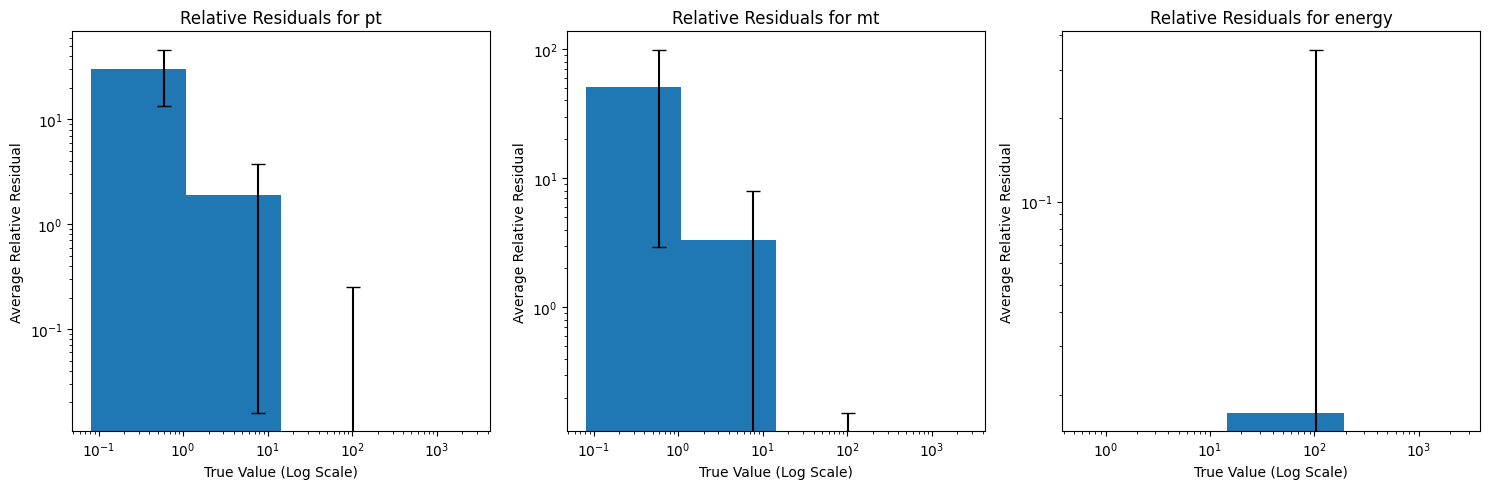

In [18]:
from scipy import stats


selected_features = ['pt', 'mt', 'energy']
selected_indices = [out_feats.index(feat) for feat in selected_features]

# Calculate relative residuals
relative_residuals = [residuals[i] / label_values[i] for i in selected_indices]

# Define logarithmic bins
bins = np.logspace(np.log10(min([min(label_values[i]) for i in selected_indices])),
                   np.log10(max([max(label_values[i]) for i in selected_indices])),
                   num=5)

fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(15, 5))

for idx, ax in enumerate(axes):
    feature_index = selected_indices[idx]
    # print(relative_residuals[idx])
    # Compute binned statistics (mean and std)
    bin_means, bin_edges, binnumber = stats.binned_statistic(label_values[feature_index],
                                                             relative_residuals[idx],
                                                             statistic='mean',
                                                             bins=bins)
    
    bin_stds, _, _ = stats.binned_statistic(label_values[feature_index],
                                            relative_residuals[idx],
                                            statistic='std',
                                            bins=bins)

    # Compute the widths of the bars
    bar_widths = np.diff(bin_edges)

    print("bin errors for feature", selected_features[idx], bin_stds)
    # Plot the bar plot with error bars
    ax.bar(x=bin_edges[:-1], height=bin_means, width=bar_widths, align='edge', yerr=bin_stds, capsize=5)
    # ax.bar(x=bin_edges[:-1], height=bin_means, width=bar_widths, align='edge', yerr=None, capsize=5)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Relative Residuals for {selected_features[idx]}')
    ax.set_xlabel('True Value (Log Scale)')
    ax.set_ylabel('Average Relative Residual')
    # break

plt.tight_layout()
plt.show()
